# Paper Implementation
## END-TO-END TRAINED CNN ENCODER-DECODER NETWORKS FOR IMAGE STEGANOGRAPHY - Atique </i> $et.al$
## Tensorflow 2.0
###  Notebook Author: Saad Zia

In [1]:
import numpy as np
import tensorflow as tf
import pickle

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# For process to not allocate entire GPU memory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)


#### Setting up Data Pipeline

In [3]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

In [5]:
# for when payload is grayscale
# payload_train = np.mean(x, axis=-1)[:5000, :, :, np.newaxis]

# for when payload is rgb
payload_train = x[:5000]

host_train = x[np.random.choice(np.arange(x.shape[0]), size=payload_train.shape[0])][:5000]

# for when payload is grayscale
payload_test = np.mean(x_test, axis=-1)[:500, :, :, np.newaxis]

# for when payload is rgb
payload_test = x[:500]

host_test = x_test[np.random.choice(np.arange(x_test.shape[0]), size=payload_test.shape[0])][:500]

In [6]:
# Instantiate the Dataset class
train_dataset = tf.data.Dataset.from_tensor_slices((payload_train, host_train))

In [7]:
# Normalization function
def normalize(payload, host):
    payload = tf.image.per_image_standardization(payload)
    host = tf.image.per_image_standardization(host)
    return payload, host

# Adding shuffle, normalization and batching operations to the dataset object
train_dataset = train_dataset.map(normalize).shuffle(5000).batch(256, drop_remainder=True)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(128, drop_remainder=True)).shuffle(500)

#### Setting up tf.keras Model

In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [25]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [26]:
from encoder import EncoderNetwork
from decoder import DecoderNetwork

In [27]:
carrier_image_shape=(32, 32, 3)
payload_image_shape=(32, 32, 3)

encoder_network = EncoderNetwork(carrier_shape=carrier_image_shape, payload_shape=payload_image_shape)
decoder_network = DecoderNetwork(target_image_shape=payload_image_shape)

In [28]:
input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [29]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [30]:
steganography_model = Model(inputs=[input_carrier, input_payload], outputs=[encoded_output, decoded_output])

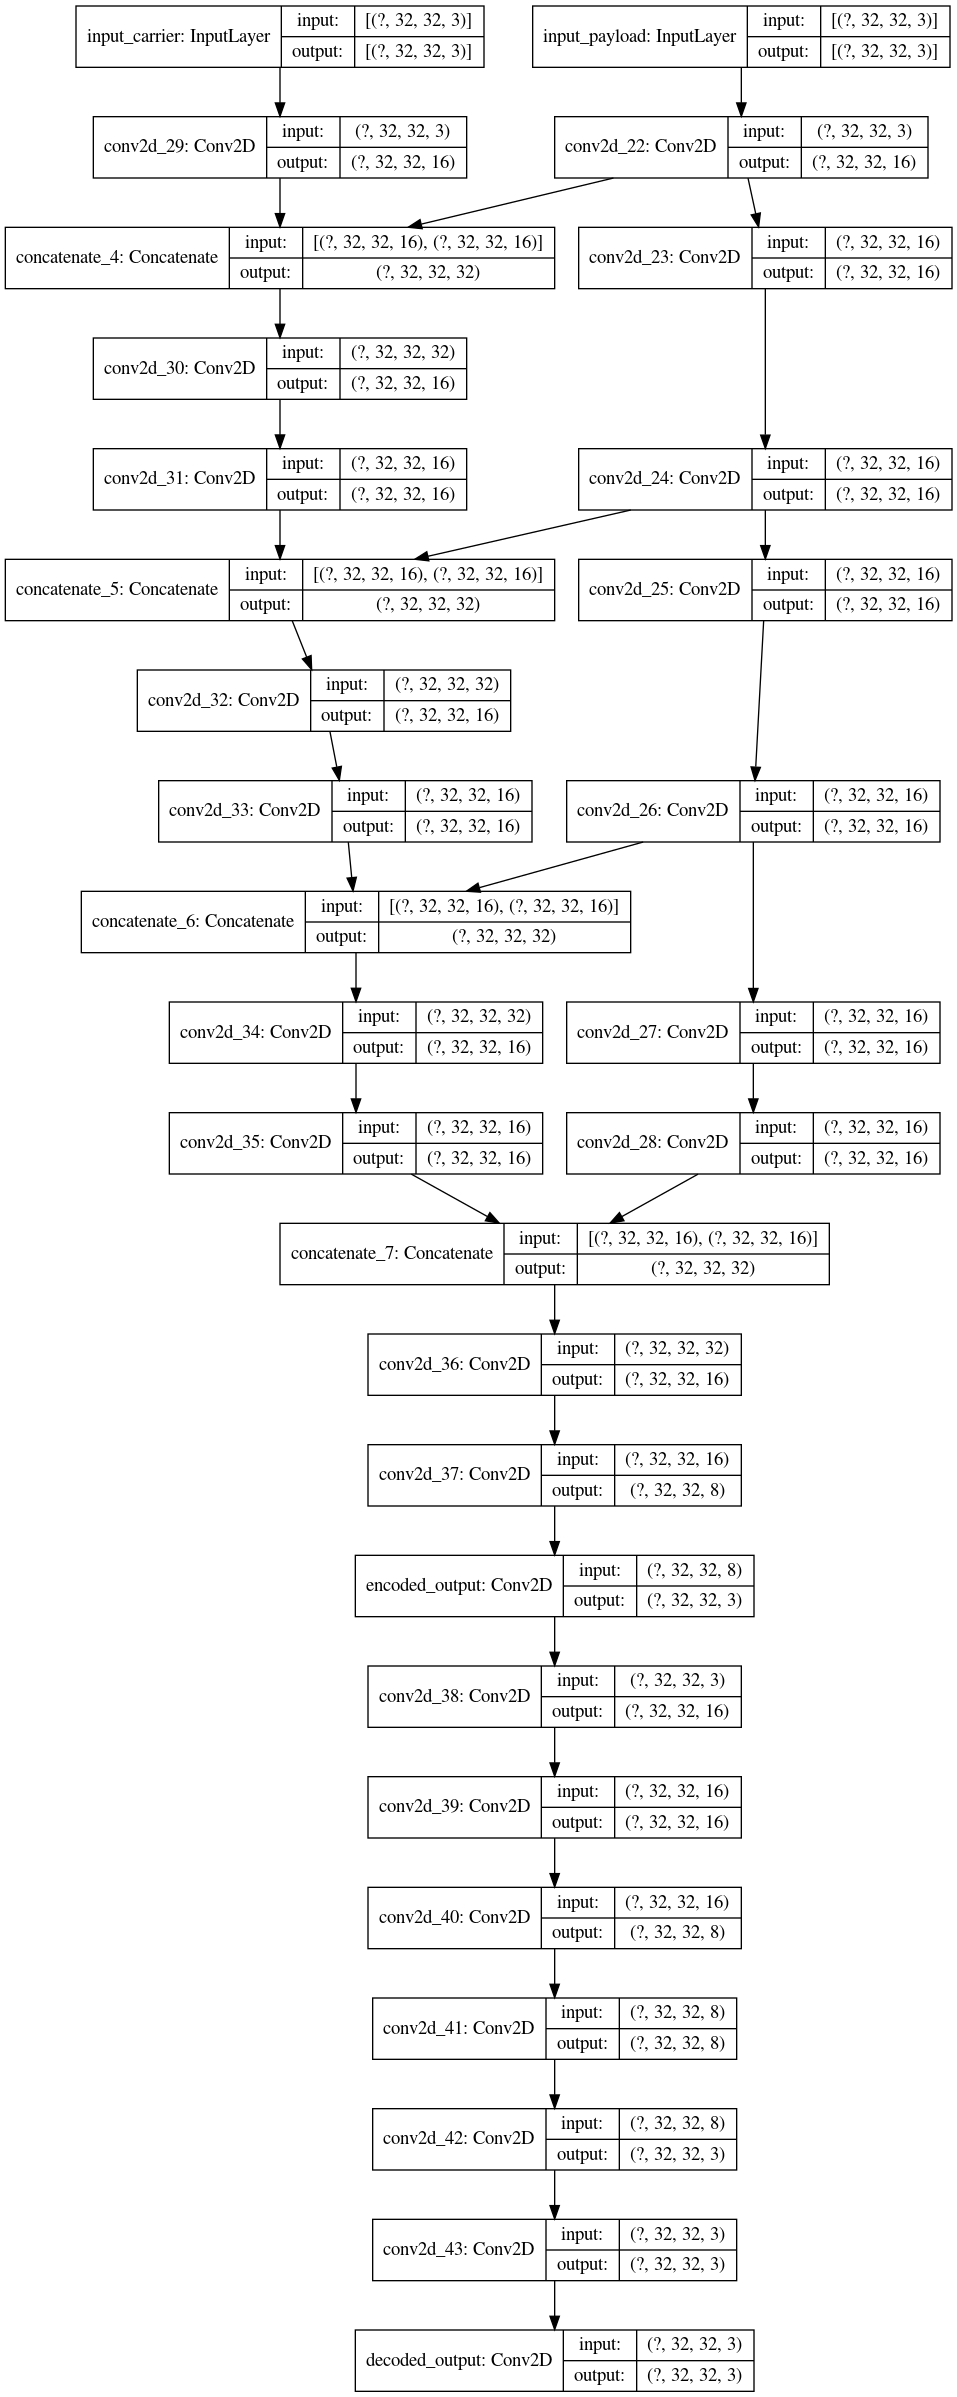

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [32]:
steganography_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_carrier (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_payload (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 16)   448         input_carrier[0][0]              
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_payload[0][0]              
____________________________________________________________________________________________

In [33]:
# Defining Loss Function

@tf.function
def loss_function(payload, host, encoder_output, decoder_output):
    
    loss = tf.math.reduce_mean(tf.math.squared_difference(payload, decoder_output)\
                           + tf.math.squared_difference(host, encoder_output))
        
    return loss


In [34]:
def custom_loss(input_):
    def loss(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    return loss             

In [35]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [64]:
a = None
for payload, host in train_dataset.batch(5000):
    a = host
    break

In [68]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, steganography_model.trainable_variables))
    
    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    train_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return train_host_psnr, train_payload_psnr



@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)
    
    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    test_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return test_host_psnr, test_payload_psnr

EPOCHS = 250
SUMMARY_DIR = './summary'

import time


for epoch in range(EPOCHS):
    start = time.time()
    for payload, host in train_dataset:
        train_host_psnr, train_payload_psnr = train_step(payload, host)

    for payload, host in test_dataset:
        test_host_psnr, test_payload_psnr = test_step(payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}, TrainH PSNR: {}, TrainP PSNR: {}, TestH PSNR: {}, TestP PSNR: {}'
    print(template.format(epoch+1, train_loss.result(), test_loss.result(), train_host_psnr,\
                         train_payload_psnr, test_host_psnr, test_payload_psnr))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

elapsed: 2.904781
Epoch 1, Train Loss: 0.5700900554656982, Test Loss: 0.5686190128326416, TrainH PSNR: 42.55171203613281, TrainP PSNR: 27.74254035949707, TestH PSNR: 43.034645080566406, TestP PSNR: 27.80188751220703
elapsed: 2.047589
Epoch 2, Train Loss: 0.5700501799583435, Test Loss: 0.568868100643158, TrainH PSNR: 42.33446502685547, TrainP PSNR: 27.764963150024414, TestH PSNR: 42.30915451049805, TestP PSNR: 27.78251075744629
elapsed: 2.076320
Epoch 3, Train Loss: 0.5700225830078125, Test Loss: 0.5694487690925598, TrainH PSNR: 42.24988555908203, TrainP PSNR: 27.692031860351562, TestH PSNR: 42.394630432128906, TestP PSNR: 27.775386810302734
elapsed: 2.055980
Epoch 4, Train Loss: 0.5697759389877319, Test Loss: 0.567550003528595, TrainH PSNR: 42.33718490600586, TrainP PSNR: 27.789186477661133, TestH PSNR: 42.5048942565918, TestP PSNR: 27.84157943725586
elapsed: 2.006746
Epoch 5, Train Loss: 0.5695685744285583, Test Loss: 0.5706283450126648, TrainH PSNR: 42.53901290893555, TrainP PSNR: 27

elapsed: 2.093452
Epoch 39, Train Loss: 0.5655860900878906, Test Loss: 0.5603917241096497, TrainH PSNR: 42.71818161010742, TrainP PSNR: 27.810836791992188, TestH PSNR: 42.65296173095703, TestP PSNR: 27.893583297729492
elapsed: 2.003011
Epoch 40, Train Loss: 0.5654857158660889, Test Loss: 0.5626428723335266, TrainH PSNR: 42.64271926879883, TrainP PSNR: 27.754161834716797, TestH PSNR: 42.497676849365234, TestP PSNR: 27.836990356445312
elapsed: 2.062405
Epoch 41, Train Loss: 0.5654039978981018, Test Loss: 0.5603135228157043, TrainH PSNR: 42.53096389770508, TrainP PSNR: 27.87128257751465, TestH PSNR: 42.615596771240234, TestP PSNR: 27.85158920288086
elapsed: 2.072188
Epoch 42, Train Loss: 0.5653032064437866, Test Loss: 0.5600277781486511, TrainH PSNR: 42.754669189453125, TrainP PSNR: 27.946672439575195, TestH PSNR: 42.6461181640625, TestP PSNR: 27.852561950683594
elapsed: 2.017369
Epoch 43, Train Loss: 0.5652056932449341, Test Loss: 0.559826672077179, TrainH PSNR: 42.80577850341797, TrainP

elapsed: 2.094500
Epoch 77, Train Loss: 0.5625169277191162, Test Loss: 0.5556910037994385, TrainH PSNR: 42.9039306640625, TrainP PSNR: 27.96603012084961, TestH PSNR: 43.46682357788086, TestP PSNR: 27.904748916625977
elapsed: 2.048486
Epoch 78, Train Loss: 0.5624452829360962, Test Loss: 0.5557916760444641, TrainH PSNR: 42.7997932434082, TrainP PSNR: 27.826631546020508, TestH PSNR: 43.47077560424805, TestP PSNR: 27.905305862426758
elapsed: 2.053962
Epoch 79, Train Loss: 0.5623761415481567, Test Loss: 0.5561497807502747, TrainH PSNR: 42.88675308227539, TrainP PSNR: 27.909191131591797, TestH PSNR: 42.79864501953125, TestP PSNR: 27.884624481201172
elapsed: 2.087834
Epoch 80, Train Loss: 0.5623072385787964, Test Loss: 0.5552950501441956, TrainH PSNR: 42.88168716430664, TrainP PSNR: 27.86794090270996, TestH PSNR: 43.47401428222656, TestP PSNR: 27.909006118774414
elapsed: 2.032062
Epoch 81, Train Loss: 0.5622313618659973, Test Loss: 0.5552064776420593, TrainH PSNR: 43.284027099609375, TrainP P

elapsed: 2.031659
Epoch 115, Train Loss: 0.5601027011871338, Test Loss: 0.5523123741149902, TrainH PSNR: 43.22669219970703, TrainP PSNR: 27.855796813964844, TestH PSNR: 42.92577362060547, TestP PSNR: 27.95103645324707
elapsed: 2.064015
Epoch 116, Train Loss: 0.5600451827049255, Test Loss: 0.5523641109466553, TrainH PSNR: 43.097843170166016, TrainP PSNR: 27.87676429748535, TestH PSNR: 42.942989349365234, TestP PSNR: 27.95038414001465
elapsed: 2.062063
Epoch 117, Train Loss: 0.5599934458732605, Test Loss: 0.5519660115242004, TrainH PSNR: 42.94437026977539, TrainP PSNR: 27.940662384033203, TestH PSNR: 42.954368591308594, TestP PSNR: 27.916118621826172
elapsed: 2.089941
Epoch 118, Train Loss: 0.5599429607391357, Test Loss: 0.5522408485412598, TrainH PSNR: 42.68315124511719, TrainP PSNR: 27.97782325744629, TestH PSNR: 42.88652801513672, TestP PSNR: 27.952922821044922
elapsed: 2.095265
Epoch 119, Train Loss: 0.5598851442337036, Test Loss: 0.5517244338989258, TrainH PSNR: 43.08842849731445, T

elapsed: 2.024274
Epoch 153, Train Loss: 0.5581647157669067, Test Loss: 0.5499400496482849, TrainH PSNR: 43.10399627685547, TrainP PSNR: 27.933374404907227, TestH PSNR: 43.76557159423828, TestP PSNR: 27.948787689208984
elapsed: 2.088028
Epoch 154, Train Loss: 0.5581191778182983, Test Loss: 0.5493250489234924, TrainH PSNR: 43.526771545410156, TrainP PSNR: 27.967470169067383, TestH PSNR: 43.749794006347656, TestP PSNR: 27.952835083007812
elapsed: 2.118837
Epoch 155, Train Loss: 0.5580754280090332, Test Loss: 0.5497025847434998, TrainH PSNR: 43.07508087158203, TrainP PSNR: 27.872926712036133, TestH PSNR: 43.76901626586914, TestP PSNR: 27.950586318969727
elapsed: 2.143946
Epoch 156, Train Loss: 0.5580388903617859, Test Loss: 0.5497373938560486, TrainH PSNR: 43.06484603881836, TrainP PSNR: 27.964065551757812, TestH PSNR: 43.72247314453125, TestP PSNR: 27.951505661010742
elapsed: 2.145122
Epoch 157, Train Loss: 0.557990312576294, Test Loss: 0.5493490695953369, TrainH PSNR: 42.97517395019531,

elapsed: 2.054394
Epoch 191, Train Loss: 0.5565305948257446, Test Loss: 0.5471504330635071, TrainH PSNR: 43.0098762512207, TrainP PSNR: 27.925411224365234, TestH PSNR: 43.1566047668457, TestP PSNR: 27.987960815429688
elapsed: 2.037625
Epoch 192, Train Loss: 0.556489109992981, Test Loss: 0.5473564267158508, TrainH PSNR: 42.795997619628906, TrainP PSNR: 27.907529830932617, TestH PSNR: 43.189247131347656, TestP PSNR: 27.951847076416016
elapsed: 2.059205
Epoch 193, Train Loss: 0.5564469695091248, Test Loss: 0.5470177531242371, TrainH PSNR: 43.576087951660156, TrainP PSNR: 27.89939308166504, TestH PSNR: 43.19738006591797, TestP PSNR: 27.95399284362793
elapsed: 2.051939
Epoch 194, Train Loss: 0.5564097762107849, Test Loss: 0.5477758049964905, TrainH PSNR: 43.0481071472168, TrainP PSNR: 27.940082550048828, TestH PSNR: 43.194969177246094, TestP PSNR: 27.945940017700195
elapsed: 2.099333
Epoch 195, Train Loss: 0.5563684701919556, Test Loss: 0.5472989082336426, TrainH PSNR: 43.41228485107422, Tr

elapsed: 2.124668
Epoch 229, Train Loss: 0.5550892949104309, Test Loss: 0.5451297760009766, TrainH PSNR: 43.4836311340332, TrainP PSNR: 27.921152114868164, TestH PSNR: 43.29111099243164, TestP PSNR: 27.968034744262695
elapsed: 2.032254
Epoch 230, Train Loss: 0.5550519824028015, Test Loss: 0.5460560321807861, TrainH PSNR: 43.72351837158203, TrainP PSNR: 27.996780395507812, TestH PSNR: 43.23902893066406, TestP PSNR: 27.99413299560547
elapsed: 2.074833
Epoch 231, Train Loss: 0.5550151467323303, Test Loss: 0.5461275577545166, TrainH PSNR: 43.20460891723633, TrainP PSNR: 27.961406707763672, TestH PSNR: 43.944358825683594, TestP PSNR: 27.975791931152344
elapsed: 2.094866
Epoch 232, Train Loss: 0.5549824237823486, Test Loss: 0.5450634956359863, TrainH PSNR: 43.465240478515625, TrainP PSNR: 28.023744583129883, TestH PSNR: 43.98924255371094, TestP PSNR: 27.981822967529297
elapsed: 2.044358
Epoch 233, Train Loss: 0.554947555065155, Test Loss: 0.5452620387077332, TrainH PSNR: 43.330055236816406, 

## Inference

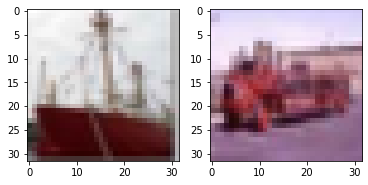

In [71]:
example_ids = np.arange(len(host_test))[:100]
example_id = np.random.choice(example_ids)

# showing host 
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]
# payload_example = np.concatenate((payload_example, np.zeros_like(payload_example), np.zeros_like(payload_example)), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


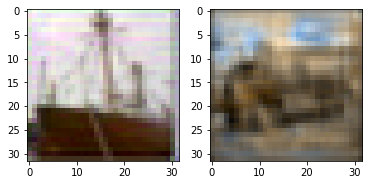

In [72]:
# showing host 
fig, axs = plt.subplots(ncols=2)

inference_dataset = tf.data.Dataset.from_tensor_slices((host_test[example_ids], payload_test[example_ids])).batch(len(example_ids))
for host, payload in inference_dataset:
    encoded_host, decoded_payload = steganography_model([host, payload])
    host_outputs = encoded_host.numpy()
    payload_output = decoded_payload.numpy()

host_output = host_outputs.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]

    
# payload_output = np.concatenate((payload_output, np.zeros_like(payload_output), np.zeros_like(payload_output)), axis=-1)
axs[0].imshow(host_output)
axs[1].imshow(payload_output)